### Recycling Robot

In [10]:
import numpy as np
import pandas as pd
from dataclasses import dataclass
from typing import Dict, Tuple, List
import matplotlib.pyplot as plt
import random
import seaborn as sns

In [ ]:
# ---------------- Config ----------------
GAMMA = 0.95               # Discount factor 
TD_LR = 0.1                # Learning rate for TD    
EPOCHS = 50                # Number of independent training cycles
STEPS_PER_EPOCH = 1000     # Steps per epoch per training cycle
NUM_RUNS = 10              # Multiple trainings to average curves
EPSILON = 0.05             # Probability of exploring random actions

# ---------------- Scenario grids ----------------
R_SEARCH_GRID = random.randint(6,10)        # Reward for finding a can
R_WAIT_GRID   = random.randint(1,3)         # Reward for waiting
RESCUE_PENALTY = -5.0                       # Penalty for being rescued
ALPHA_GRID = [0.3, 0.6, 0.9]                # Risky searching, Moderate, Very Safe (Probability that the battery stay High after a Search)
BETA_GRID =  [0.3, 0.6, 0.9]                # Dangerous to search, Moderate, Very Safe (Probability that the battery stay Low after a Search)

# --------------- Environment ---------------
STATE_H, STATE_L = 0, 1
A_SEARCH, A_WAIT, A_RECHARGE = 0, 1, 2
STATE_NAMES  = ["high", "low"]
ACTION_NAMES = ["search", "wait", "recharge"]
START_STATE = 0            
BASE_SEED   = 2025

# --------------- Output Files ---------------
REWARDS_PATH = "rewards.txt"           
REWARDS_FIG = "accumulated_reward.png"
POLICY_HEATMAP_FIG = "optimal_policy_heatmap.png"


In [ ]:
@dataclass
class Params:
    alpha: float
    beta: float
    gamma: float
    rescue_penalty: float
    r_search: int   
    r_wait: int     

def valid_actions(s: int) -> List[int]:
    return [A_SEARCH, A_WAIT] if s == STATE_H else [A_SEARCH, A_WAIT, A_RECHARGE]

def step_env(rng: np.random.Generator, s: int, a: int, p: Params) -> Tuple[int, float]:
    if s == STATE_H:
        if a == A_SEARCH:
            r = rng.integers(p.r_search - 3, p.r_search + 4)
            s_next = STATE_H if rng.random() < p.alpha else STATE_L
            return s_next, r
        elif a == A_WAIT:
            r = rng.integers(p.r_wait - 1, p.r_wait + 2)
            return STATE_H, r
    else:
        if a == A_SEARCH:
            if rng.random() < p.beta:
                r = rng.integers(p.r_search - 3, p.r_search + 4)
                return STATE_L, r
            else:
                return STATE_H, p.rescue_penalty
        elif a == A_WAIT:
            r = rng.integers(p.r_wait - 1, p.r_wait + 2)
            return STATE_L, r
        elif a == A_RECHARGE:
            return STATE_H, 0.0

def choose_action(rng, s, V, p: Params, epsilon: float) -> int:
    valid = valid_actions(s)
    if rng.random() < epsilon: return rng.choice(valid)

    q_values = []
    for a in valid:
        if s == STATE_H:
            if a == A_SEARCH:
                q = p.r_search + p.gamma * (p.alpha * V[STATE_H] + (1 - p.alpha) * V[STATE_L])
            elif a == A_WAIT:
                q = p.r_wait + p.gamma * V[STATE_H]
        else:
            if a == A_SEARCH:
                q = p.beta * (p.r_search + p.gamma * V[STATE_L]) \
                  + (1 - p.beta) * (p.rescue_penalty + p.gamma * V[STATE_H])
            elif a == A_WAIT:
                q = p.r_wait + p.gamma * V[STATE_L]
            elif a == A_RECHARGE:
                q = 0.0 + p.gamma * V[STATE_H]
        q_values.append(q)
    return valid[int(np.argmax(q_values))]

def td_update(V: np.ndarray, s: int, r: float, s_next: int, p: Params, lr: float) -> None:
    """
    Update value function V using TD(0).
    """
    V[s] += lr * (r + p.gamma * V[s_next] - V[s])

def train_td(rng: np.random.Generator, p: Params, epochs: int, steps_per_epoch: int, lr: float, epsilon: float) -> np.ndarray:
    """
    Train the Recycling Robot with TD learning.
    
    Returns:
        V: learned state values
    """
    V = np.zeros(2)     # Two states: High, Low

    for ep in range(epochs):
        s = STATE_H  
        for _ in range(steps_per_epoch):
            a         = choose_action(rng, s, V, p, epsilon)
            s_next, r = step_env(rng, s, a, p)
            td_update(V, s, r, s_next, p, lr)
            s = s_next  
    return V

In [ ]:
# Run multiple training runs to average rewards and return the average accumulated rewards per epoch.
def run_experiments(p: Params, num_runs, epochs, steps_per_epoch, lr, epsilon, seed=BASE_SEED):
    rewards_all = np.zeros((num_runs, epochs))
    for run in range(num_runs):
        # Offset seed by scenario so each (alpha,beta) has a different random stream
        scenario_offset = 100000*int(round(p.alpha*100)) + 1000*int(round(p.beta*100))
        rng = np.random.default_rng(seed + run + scenario_offset)

        V = np.zeros(2)
        for ep in range(epochs):
            s = STATE_H
            total = 0.0
            for _ in range(steps_per_epoch):
                a = choose_action(rng, s, V, p, epsilon)
                s_next, r = step_env(rng, s, a, p)
                V[s] += lr * (r + p.gamma * V[s_next] - V[s])  # TD(0)
                total += r
                s = s_next
            rewards_all[run, ep] = total
    return rewards_all.mean(axis=0), V


# Plot accumulated rewards over epochs.
def plot_rewards_curve(rewards_avg: np.ndarray): 
    plt.figure(figsize=(8,5))
    plt.plot(rewards_avg, label="Average total reward")
    plt.xlabel("Epoch")
    plt.ylabel("Accumulated reward")
    plt.title("Recycling Robot – Learning Curve")
    plt.legend()
    plt.grid(True)
    plt.savefig(REWARDS_FIG, dpi=300)
    # plt.close()

# Plot the optimal policy as a heatmap.
def plot_policy_heatmap(V: np.ndarray, p: Params):
    policy = {}
    for s in [STATE_H, STATE_L]:
        valid = valid_actions(s)
        qvals = [0.0] * len(ACTION_NAMES)
        for a in valid:
            if s == STATE_H:
                if a == A_SEARCH:
                    qvals[a] = p.r_search + p.gamma * (p.alpha * V[STATE_H] + (1 - p.alpha) * V[STATE_L])
                elif a == A_WAIT:
                    qvals[a] = p.r_wait + p.gamma * V[STATE_H]
            else:  
                if a == A_SEARCH:
                    qvals[a] = p.beta * (p.r_search + p.gamma * V[STATE_L]) + (1 - p.beta) * (p.rescue_penalty + p.gamma * V[STATE_H])
                elif a == A_WAIT:
                    qvals[a] = p.r_wait + p.gamma * V[STATE_L]
                elif a == A_RECHARGE:
                    qvals[a] = 0.0 + p.gamma * V[STATE_H]

        qvals = np.array(qvals)
        probs = np.exp(qvals - np.max(qvals))
        probs /= probs.sum()
        policy[s] = probs

    heatmap_data = np.zeros((len(STATE_NAMES), len(ACTION_NAMES)))
    for s in policy: heatmap_data[s, :] = policy[s]

    plt.figure(figsize=(6,3))
    sns.heatmap(heatmap_data, annot=True, fmt=".2f", xticklabels=ACTION_NAMES, yticklabels=STATE_NAMES, cmap="Blues")
    plt.title("Optimal Policy (action probabilities)")
    plt.savefig(POLICY_HEATMAP_FIG, dpi=300)
    # plt.close()

### Validation Setup

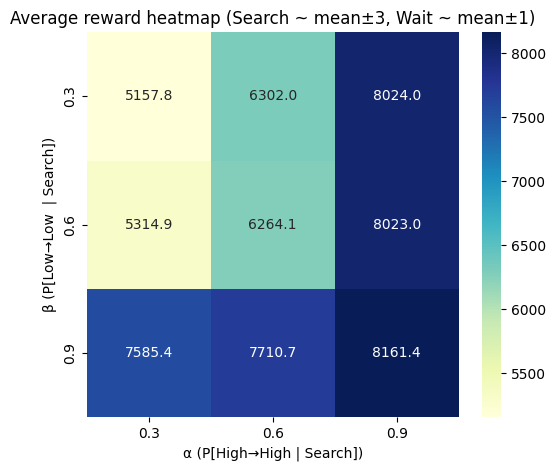

In [34]:
ALPHA_GRID = [0.3, 0.6, 0.9]
BETA_GRID  = [0.3, 0.6, 0.9]

results = []
for beta in BETA_GRID:
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha, beta=beta,
                   gamma=GAMMA, rescue_penalty=RESCUE_PENALTY,
                   r_search=9,  
                   r_wait=2)    
        rewards_avg, V = run_experiments(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
        results.append({"alpha": alpha, "beta": beta, "reward": float(rewards_avg.mean())})

df = pd.DataFrame(results)
reward_matrix = df.pivot(index="beta", columns="alpha", values="reward")

plt.figure(figsize=(6,5))
sns.heatmap(reward_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title("Average reward heatmap (Search ~ mean±3, Wait ~ mean±1)")
plt.xlabel("α (P[High→High | Search])")
plt.ylabel("β (P[Low→Low  | Search])")
plt.show(); plt.close()

In [32]:
ALPHA_GRID = [0.3, 0.6, 0.9]
BETA_GRID = [0.3, 0.6, 0.9]
results = []
r_search = 9
r_wait = 2 
for beta in BETA_GRID:
    for alpha in ALPHA_GRID:
        p = Params(alpha=alpha,
                   beta=beta,
                   r_search=r_search,
                   r_wait=r_wait,
                   gamma=GAMMA,
                   rescue_penalty=RESCUE_PENALTY)

        rewards_avg, V = run_experiments(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
        avg_reward = rewards_avg.mean()  
        results.append({"alpha": alpha, "beta": beta, "reward": avg_reward})
df = pd.DataFrame(results)
reward_matrix = df.pivot(index="beta", columns="alpha", values="reward")


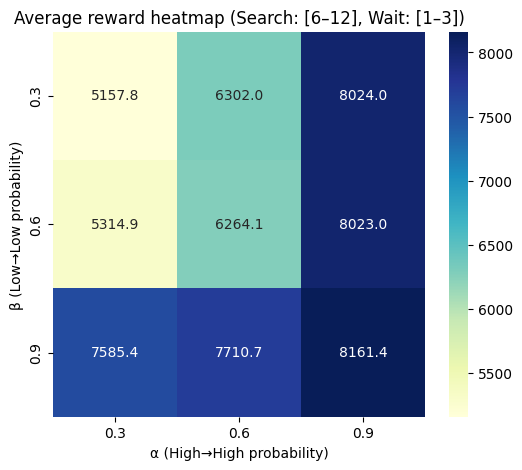

In [33]:
plt.figure(figsize=(6,5))
sns.heatmap(reward_matrix, annot=True, fmt=".1f", cmap="YlGnBu")
plt.title(f"Average reward heatmap (Search: [{r_search-3}–{r_search+3}], Wait: [{r_wait-1}–{r_wait+1}])")
plt.xlabel("α (High→High probability)")
plt.ylabel("β (Low→Low probability)")
plt.show()
# plt.close()

### Testing Setup

Training complete. Results saved to:
- Rewards file: rewards.txt
- Rewards plot: accumulated_reward.png
- Policy heatmap: optimal_policy_heatmap.png


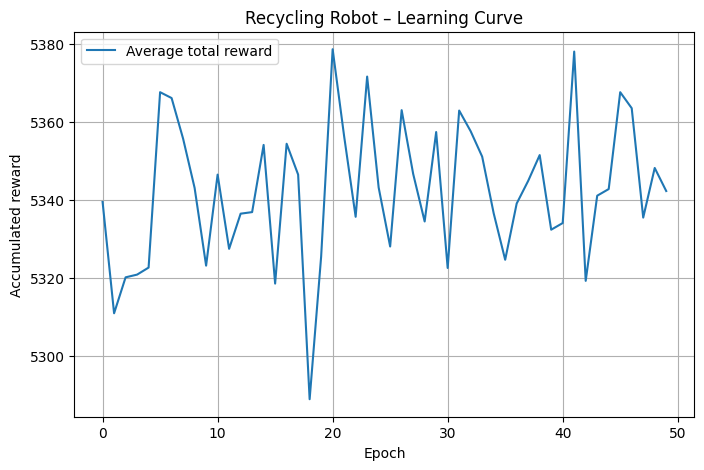

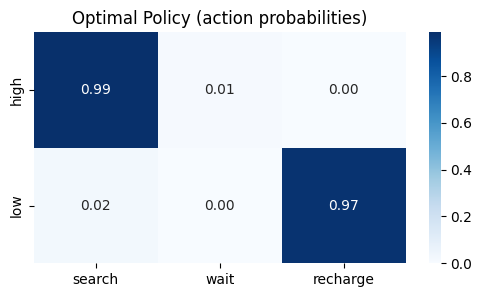

In [13]:
if __name__ == "__main__":
    p = Params(alpha=0.9,
               beta=0.3,
               r_search=R_SEARCH_GRID,
               r_wait=R_WAIT_GRID,
               gamma=GAMMA,
               rescue_penalty=RESCUE_PENALTY)

    rewards_avg, V = run_experiments(p, NUM_RUNS, EPOCHS, STEPS_PER_EPOCH, TD_LR, EPSILON)
    plot_rewards_curve(rewards_avg)
    plot_policy_heatmap(V, p)

    print("Training complete. Results saved to:")
    print(f"- Rewards file: {REWARDS_PATH}")
    print(f"- Rewards plot: {REWARDS_FIG}")
    print(f"- Policy heatmap: {POLICY_HEATMAP_FIG}")